In [39]:
from __future__ import print_function
import urllib
import bz2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import matplotlib.image as mpimg
import cv2
import plotly.graph_objs as go
import os
from utils.utils_IO import ordered_arr_3d_to_dict, refill_nan_array, arr_2d_to_list_of_dicts, read_image, make_image_array, revert_ordered_arr_2d_to_dict, save_object, write_video
from utils.utils_plotting import plot_image_labels, plot_3d_points, vector_plot, draw_circles, slope, drawLine, skew, plot_cams_and_points
from utils.utils_BA import fun, bundle_adjustment_sparsity, project
from anipose_BA import CameraGroup, Camera
from scipy.spatial.transform import Rotation as R
from pathlib import Path
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and process data

In [40]:
import h5py
data_dir = Path('./CostaData').resolve()

#Read cam 1 points
filename = data_dir / 'camera-1_09-15DeepCut_resnet50_Joystick_cam1Sep13shuffle1_140000.h5'
f = h5py.File(filename, 'r')
data_1 = f['df_with_missing']['table']
#Hand is removed at image 1178, so index is 1 less:
im_start = 1178
arr_start_idx = im_start - 1
data_1 = data_1[arr_start_idx:]
data_1 = data_1['values_block_0']

#Read cam 2 points
filename = data_dir / 'camera-2_09-15DeepCut_resnet50_Joystick_cam2Sep13shuffle1_160000.h5'
f = h5py.File(filename, 'r')
data_2 = f['df_with_missing']['table']
#Hand is removed at image 1178, so index is 1 less:
im_start = 1178
arr_start_idx = im_start - 1
data_2 = data_2[arr_start_idx:]
data_2 = data_2['values_block_0']

In [41]:
import re
def sorted_nicely(l):
    """ Sort the given iterable in the way that humans expect."""
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [42]:
#Set up path_images
cam_1_image_path = data_dir / 'cam_1_09_15_all_images/'
cam_2_image_path = data_dir / 'cam_2_09_15_all_images/'

cam_1_images = sorted_nicely(os.listdir(cam_1_image_path))
cam_2_images = sorted_nicely(os.listdir(cam_2_image_path))

if ".DS_Store" in cam_1_images:
    cam_1_images.remove(".DS_Store")
if ".DS_Store" in cam_2_images:
    cam_2_images.remove(".DS_Store")

#Find index
for idx, i in enumerate(cam_1_images):
    if str(im_start) in i:
        cam1_start_idx=idx
        break
cam_1_images = cam_1_images[cam1_start_idx:]

for idx, i in enumerate(cam_2_images):
    if str(im_start) in i:
        cam2_start_idx=idx
        break
cam_2_images = cam_2_images[cam2_start_idx:]

#Append paths to each filename
cam_1_images = [cam_1_image_path / i for i in cam_1_images]
cam_2_images = [cam_2_image_path / i for i in cam_2_images]

assert len(cam_1_images) == len(cam_2_images)
path_images = [cam_1_images, cam_2_images]

In [43]:
# Ignore likelihoods, only take points. Columns to delete 2,5,8
data_1 = np.delete(data_1, [2,5,8], 1)
data_2 = np.delete(data_2, [2,5,8], 1)

In [44]:
#Set up pts_array_2d
#re-organize camera 1
pts_2d_cam1_x = data_1[:, [0,2,4]]
pts_2d_cam1_y = data_1[:, [1,3,5]]

pts_2d_cam1_x = np.ravel(pts_2d_cam1_x)[:, np.newaxis]
pts_2d_cam1_y = np.ravel(pts_2d_cam1_y)[:, np.newaxis]

pts_2d_cam1 = np.concatenate((pts_2d_cam1_x, pts_2d_cam1_y), axis=-1)[np.newaxis, :, :]

#re-organize camera 2
pts_2d_cam2_x = data_2[:, [0,2,4]]
pts_2d_cam2_y = data_2[:, [1,3,5]]

pts_2d_cam2_x = np.ravel(pts_2d_cam2_x)[:, np.newaxis]
pts_2d_cam2_y = np.ravel(pts_2d_cam2_y)[:, np.newaxis]

pts_2d_cam2 = np.concatenate((pts_2d_cam2_x, pts_2d_cam2_y), axis=-1)[np.newaxis, :, :]

#Now combine
pts_array_2d = np.concatenate((pts_2d_cam1, pts_2d_cam2), axis=0)

# Requirements for Bundle Adjustment

In [45]:
#Set up info_dict:
info_dict = {}

num_frames = data_1.shape[0]
info_dict['num_frames'] = num_frames

num_analyzed_body_parts = 3
info_dict['num_analyzed_body_parts'] = num_analyzed_body_parts

num_cameras = 2
info_dict['num_cameras'] = num_cameras

num_points_all = pts_array_2d.shape[1]
info_dict['num_points_all'] = num_points_all

clean_point_indices = np.arange(pts_array_2d.shape[1])
info_dict['clean_point_indices'] = clean_point_indices

In [46]:
#Image size is 640x512
P_X_TOP = 320
P_X_BOT = 320

P_Y_TOP = 256
P_Y_BOT = 256

#`P_{X,Y}_{TOP,BOT}`: (int) - {width / 2, height / 2} for camera {1,2}

-->For setting the offset terms in the camera matrix to the center of the image plane


`pts_array_2d`: (np.array) - Array of shape (num_cameras, num_points, 2) containing set of 2d points for each camera. This should be after cleaning NaNs i.e. removing rows with NaNs

`info_dict`: Dictionary with keys {'num_frames', 'num_analyzed_body_parts', 'num_cameras', 'num_points_all', 'clean_point_indices'}

--> 'num_frames' is the number of frames in the video

--> 'num_analyzed_body_parts' is the number of body parts / joints being modeled (i.e. one per keypoint)

--> 'num_cameras' is the number of cameras. In our case, it is 2

--> 'num_points_all' is the original number of points (including NaNs)

--> 'clean_point_indices' is a list of indices (with length = num_points in `pts_array_2d`) pointing to the clean (non-NaN) entries in the original data

`path_images`: (list) - List of sublists. Each sublist (one per camera / view) contains absolute paths to image frames. 


In [47]:
import pickle
from pathlib import Path
def save_object(obj, filename, objects_dir='./rick_data_objects/'):
    with open(Path(objects_dir) / filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

def load_object(filename, objects_dir='./rick_data_objects/'):
    obj = None
    with open(Path(objects_dir) / filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [48]:
'''
save_object(info_dict, 'info_dict.pkl')
save_object(pts_array_2d, 'pts_array_2d.pkl')
offsets = [P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT]
save_object(offsets, 'offsets.pkl')
save_object(path_images, 'path_images.pkl')
'''

"\nsave_object(info_dict, 'info_dict.pkl')\nsave_object(pts_array_2d, 'pts_array_2d.pkl')\noffsets = [P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT]\nsave_object(offsets, 'offsets.pkl')\nsave_object(path_images, 'path_images.pkl')\n"

In [49]:
'''
#Load
info_dict = load_object('info_dict.pkl')
pts_array_2d = load_object('pts_array_2d.pkl')
offsets = load_object('offsets.pkl')
path_images = load_object('path_images.pkl')
[P_X_TOP, P_Y_TOP, P_X_BOT, P_Y_BOT] = offsets
'''

IMG_WIDTH = P_X_TOP * 2
TOP_IMG_HEIGHT = P_Y_TOP * 2

# Bundle Adjust

In [50]:
#--------CAMERA 1------------
#Initialize camera 1
camera_1 = Camera(rvec=[0,0,0], tvec=[0,0,0])
#Set offset
camera_1.set_size((P_X_TOP, P_Y_TOP))

cam1_init_params = np.abs(np.random.rand(8))
#Set rotations [0:3] and translation [3:6] to 0
cam1_init_params[0:6] = 0
#Initialize focal length to image width
cam1_init_params[6] = P_X_TOP * 2
#Initialize distortion to 0
cam1_init_params[7] = 0.0 
#Set parameters
camera_1.set_params(cam1_init_params)

#--------CAMERA 2------------
#Set rotation vector w.r.t. camera 1
rvec2 = np.pi/4 * np.array([0, -1, 0])
#rvec2 = [0,0,0]
#Set translation vector w.r.t. camera 1\
tvec2 = [4, 1, 0]
#Initialize camera 2
camera_2 = Camera(rvec=rvec2, tvec=tvec2)
#Set offset 
camera_1.set_size((P_X_BOT, P_Y_BOT))

cam2_init_params = np.abs(np.random.rand(8))
cam2_init_params[0:3] = rvec2
cam2_init_params[3:6] = tvec2
cam2_init_params[6] = P_X_BOT * 2
cam2_init_params[7] = 0.0
camera_2.set_params(cam2_init_params)

#Group cameras
cam_group = CameraGroup(cameras=[camera_1, camera_2])

In [51]:
#Get error before Bundle Adjustment by triangulating using the initial parameters:
f0, points_3d_init = cam_group.get_initial_error(pts_array_2d)
print(points_3d_init.shape)

(25299, 3)


In [52]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d_init, title="3D Points Initialized")

In [53]:
#Run Bundle Adjustment
res, points_3d = cam_group.bundle_adjust(pts_array_2d)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.6226e+07                                    1.75e+08    
       1              2         4.4045e+05      5.58e+07       2.83e+01       9.54e+06    
       2              5         3.3883e+05      1.02e+05       4.86e+01       2.36e+06    
       3              6         3.0791e+05      3.09e+04       8.11e+01       4.57e+06    
       4              7         2.6844e+05      3.95e+04       7.00e+01       3.91e+06    
       5              9         2.4032e+05      2.81e+04       1.58e+01       3.21e+05    
       6             10         2.3476e+05      5.55e+03       3.37e+01       2.12e+06    
       7             11         2.2154e+05      1.32e+04       2.94e+01       1.55e+06    
       8             13         2.1480e+05      6.73e+03       1.45e+01       4.84e+05    
       9             14         2.1241e+05      2.39e+03       3.06e+01       2.43e+06    

In [54]:
fig = plot_cams_and_points(cam_group=cam_group, points_3d=points_3d, title="3D Points Bundle Adjusted")

In [55]:
#Get projected points
points_proj_1 = camera_1.project(points_3d, ).squeeze()
points_proj_2 = camera_2.project(points_3d).squeeze()
points_proj = np.concatenate((points_proj_1, points_proj_2), axis=0)
print('rot 1 bef: ', camera_1.init_rot)
print('rot 1 aft: ', camera_1.get_rotation())

print('rot 2 bef: ', camera_2.init_rot)
print('rot 2 aft: ', camera_2.get_rotation())

print("trans 1 bef: ", camera_2.init_trans)
print("trans 1 aft: ", camera_2.get_translation())


print('f_1: ', camera_1.get_focal_length())
print('f_2: ', camera_2.get_focal_length())
print('dist_1: ', camera_1.get_distortions())
print('dist_2: ', camera_2.get_distortions())


rot 1 bef:  [0, 0, 0]
rot 1 aft:  [0. 0. 0.]
rot 2 bef:  [ 0.         -0.78539816  0.        ]
rot 2 aft:  [ 0.         -0.78539816  0.        ]
trans 1 bef:  [4, 1, 0]
trans 1 aft:  [ 4.40675577  0.82634275 -2.08507387]
f_1:  557.49308316243
f_2:  250.6434554161112
dist_1:  [0. 0. 0. 0. 0.]
dist_2:  [0. 0. 0. 0. 0.]


In [56]:
plot_folder = 'rick_plots'
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)

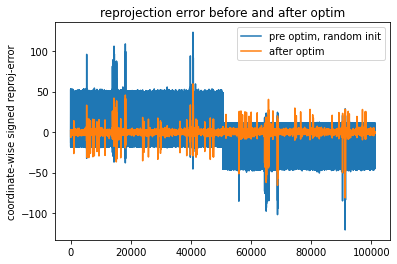

In [57]:
plt.plot(f0, label = 'pre optim, random init')
plt.plot(res.fun, label = 'after optim')
plt.legend()
plt.ylabel('coordinate-wise signed reproj-error')
plt.title('reprojection error before and after optim')
plt.savefig(os.path.join(plot_folder,'reproj-err-per-frame-initdlc3d.png'))

In [58]:
# now we first refill the full sized containers, then revert to dicts.

# do the pts_array_3d_clean
array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
pose_dict_3d_refill = ordered_arr_3d_to_dict(array_3d_back, info_dict)

# pts_3d_BA
BA_array_3d_back = refill_nan_array(points_3d, 
                               info_dict, 
                               dimension = '3d')
BA_dict = ordered_arr_3d_to_dict(BA_array_3d_back, info_dict)

# pts_2d_orig
pts_array_2d_og = np.reshape(pts_array_2d, (pts_array_2d.shape[0] * pts_array_2d.shape[1], -1))
array_2d_orig = refill_nan_array(pts_array_2d_og, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_orig = arr_2d_to_list_of_dicts(array_2d_orig,
                                              info_dict)
                                              
# pts_2d_reproj
array_2d_reproj_back = refill_nan_array(points_proj, 
                              info_dict, 
                               dimension = '2d')
pose_list_2d_reproj = arr_2d_to_list_of_dicts(array_2d_reproj_back,
                                              info_dict)

In [59]:
joined_list_2d = pose_list_2d_orig + pose_list_2d_reproj
joined_list_3d = []
joined_list_3d.append(pose_dict_3d_refill)
joined_list_3d.append(BA_dict)

In [60]:
#Red = ground truth, blue = proj
color_list_2d = ['red', 'red', 'blue', 'blue']
label_list = ['DLC', 'DLC', 'BA re-projection', 'BA re-projection']
color_list_3d = ['red', 'blue']
# set limits to be the maximum of the two plots
# we are padding the limits of the axis since some points lie at the border.
pad = 1
lims = {}
x_min = np.nanmin(BA_dict['x_coords'])
x_max = np.nanmax(BA_dict['x_coords'])
y_min = np.nanmin(BA_dict['y_coords'])
y_max = np.nanmax(BA_dict['y_coords'])
z_min = np.nanmin(BA_dict['z_coords'])
z_max = np.nanmax(BA_dict['z_coords'])
lims['x'] = [x_min, x_max]
lims['y'] = [y_min, y_max]
lims['z'] = [z_min, z_max]


In [61]:
ind_start = 155
ind_end = 155

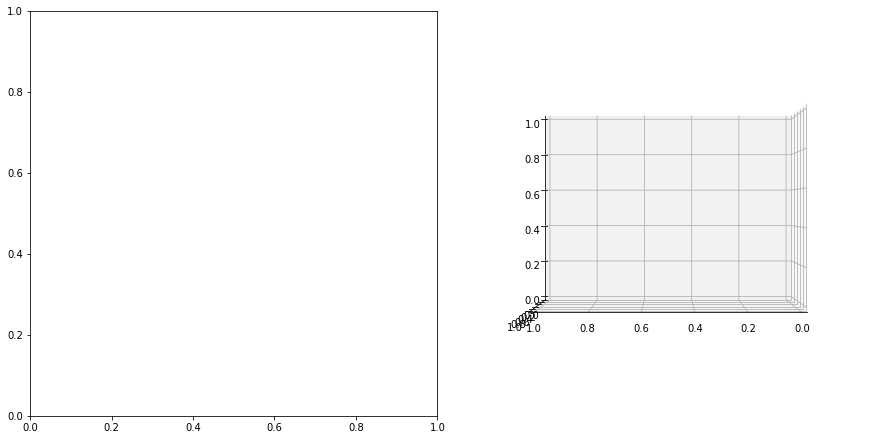

In [62]:
#### 3d plot
from matplotlib.gridspec import GridSpec
import mpl_toolkits.mplot3d.axes3d as p3
%matplotlib inline

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1], projection = '3d') # https://matplotlib.org/3.1.1/gallery/mplot3d/subplot3d.html
image_folder = 'images_test'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

ax2.view_init(elev=0, azim=90) # see https://stackoverflow.com/questions/12904912/how-to-set-camera-position-for-3d-plots-using-python-matplotlib

#FRONT RIGHT PAW
for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    ax2.cla()   
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)
    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        label_list=label_list,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)
    
    ax2.azim += 1
    plot_3d_points(joined_list_3d,
                   lims,
                   i,
                   color_list_3d,
                   ax=ax2)
    im_int = str('%.5i' % i)

    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list_reduced = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list_reduced:
            handle_list.append(handle)
            label_list_reduced.append(label)
    plt.legend(handle_list, label_list_reduced)

    plt.savefig(image_folder + '/' + 'im' + im_int + '.png')


In [63]:
write_video(image_dir='./images_test/', out_file='reconstruction.mp4')

# Plot Bundle Adjusted Through Time

In [64]:
#Get axis lims
x_min = np.nanmin(BA_dict['x_coords'])
x_max = np.nanmax(BA_dict['x_coords'])
y_min = np.nanmin(BA_dict['y_coords'])
y_max = np.nanmax(BA_dict['y_coords'])
z_min = np.nanmin(BA_dict['z_coords'])
z_max = np.nanmax(BA_dict['z_coords'])
scene_lims = [[x_min,x_max], [y_min,y_max], [z_min,z_max]]

In [65]:
plot_dir = Path('./3d_point_plots/')
plot_dir.mkdir(exist_ok=True, parents=True)
for i in range(ind_start, ind_end):
    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    fig = plot_cams_and_points(points_3d=slice_3d, scene_lims=None, point_size=5, scene_aspect='cube', show_plot=False, title="3D Points Through Time")
    fig.write_image(str(plot_dir / f"points_{i}.png"))

In [66]:
write_video(image_dir=plot_dir, out_file="points_through_time.mp4")

# Plot Skeleton

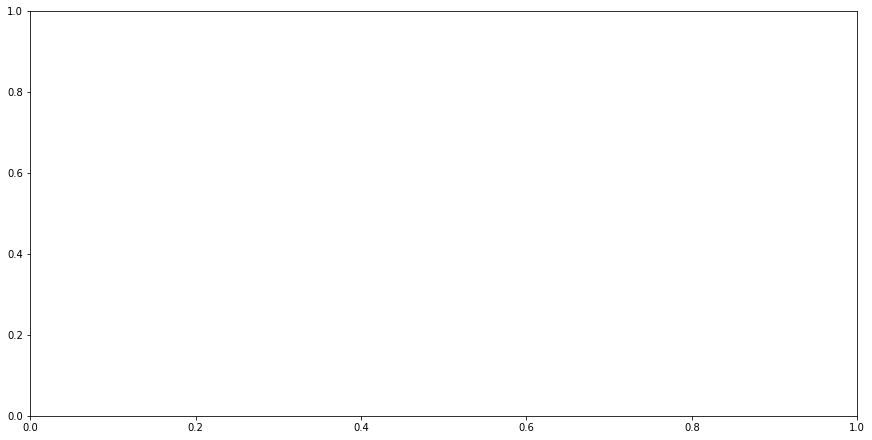

In [67]:
#### 3d plot
from matplotlib.gridspec import GridSpec

%matplotlib inline
plot_dir = Path('./3d_point_plots/')

fig = plt.figure(constrained_layout=True, figsize = (12,6))
gs = GridSpec(1, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)


for i in range(ind_start,ind_end):
    # clear both ax1 and ax2
    ax1.cla()
    # load image
    img_1 = read_image(path_images[0][i], flip=False)
    img_2 = read_image(path_images[1][i], flip=False)
    img = np.concatenate((img_1, img_2), axis=0)

    plot_image_labels(img,\
                        joined_list_2d,
                        i,
                        color_list_2d,
                        label_list,
                        ax = ax1, top_img_height=TOP_IMG_HEIGHT)

    im_int = str('%.5i' % i)

    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list_reduced = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list_reduced:
            handle_list.append(handle)
            label_list_reduced.append(label)
    plt.legend(handle_list, label_list_reduced)

    plt.savefig(str(plot_dir / ('im' + im_int + '.png')),bbox_inches='tight', pad_inches=0)

In [68]:
#['nose', 'paw1LH', 'paw2LF', 'paw3RF', 'paw4RH', 'tailBase', 'tailMid']
#0: nose
#1: left front paw
#2: left back paw
#3: right back paw
#4: right front
#5: tail base
#6: tail mid

In [69]:
#Plot skeleton
from PIL import Image

for i in range(ind_start, ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)
    width, height = proj_img.size
    #height, width = proj_img.size

    slice_3d = np.asarray([BA_dict['x_coords'][i], BA_dict['y_coords'][i],BA_dict['z_coords'][i]]).transpose()
    
    #Add coordinates of each bodypart to dict
    skeleton_bp = {}
    skeleton_bp['p1'] = (BA_dict['x_coords'][i][0], BA_dict['y_coords'][i][0], BA_dict['z_coords'][i][0])
    skeleton_bp['p2'] = (BA_dict['x_coords'][i][1], BA_dict['y_coords'][i][1], BA_dict['z_coords'][i][1])
    skeleton_bp['p3'] = (BA_dict['x_coords'][i][2], BA_dict['y_coords'][i][2], BA_dict['z_coords'][i][2])
    #Draw vector from tail_base to tail_mid
    #for index in range(1,5):
    #    skeleton_bp[f"paw_{index}"] = (BA_dict['x_coords'][i][index], BA_dict['y_coords'][i][index], BA_dict['z_coords'][i][index])

    #Now, define lines:
    #List of tuples indicating line from bodypart to bodypart, e.g. [('nose', 'tail_base')]
    #   draws a line from the nose to the base of the tail.
    #Also, to specify a midpoint, use a tuple in the tuple, e.g. [(('nose', 'tail_base'), 'paw_1')]
    #   draws a line from the midpoint of 'nose' and 'tail_base' to a paw.

    skeleton_lines = [('p1', 'p2'), ('p2', 'p3')]
    #For each paw
    #for index in range(1):
    #    #Draw a line from the midpoint of nose and tail_base to each paw
    #    skeleton_lines.append((('nose', 'tail_base'), f'paw_{index}'))


    #---------Plot 3D points with skeleton
    scene_camera = dict(
        up=dict(x=0, y=0, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-1, y=-1, z=-2.5)
    )

    fig = plot_cams_and_points(points_3d=slice_3d, scene_lims=scene_lims, point_size=5, scene_aspect='cube',                                scene_camera=scene_camera, show_plot=False, title="3D Points Through Time", skeleton_bp=skeleton_bp,                                skeleton_lines=skeleton_lines)
    fig.update_layout(showlegend=False)

    fig.write_image(str(plot_dir / f"3dpoints_{i}.png"), width=width, height=height)

    #--------------Now repeat, but include cameras in plot

    scene_camera = dict(
        up=dict(x=0, y=0, z=0),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=0, y=-1, z=-2.5)
    )

    fig = plot_cams_and_points(cam_group=cam_group, points_3d=slice_3d, point_size=5, scene_aspect='cube',                                scene_camera=scene_camera, show_plot=False, title="3D Points Through Time", skeleton_bp=skeleton_bp,                                skeleton_lines=skeleton_lines)
    fig.update_traces(textfont_size=1)
    fig.update_layout(showlegend=False)
    fig.write_image(str(plot_dir / f"3dpoints_cams_{i}.png"), width=width, height=height)

In [70]:
#Combine images
from pathlib import Path
from utils.utils_IO import read_image
import numpy as np
from PIL import Image

combined_dir = Path('./combined/')
combined_dir.mkdir(parents=True, exist_ok=True)
for i in range(ind_start,ind_end):
    im_int = str('%.5i' % i)
    proj_im_path = plot_dir / f"im{im_int}.png"
    proj_img = Image.open(proj_im_path)


    point_im_path = plot_dir / f"3dpoints_{i}.png"
    points_img = Image.open(point_im_path)

    cam_im_path = plot_dir / f"3dpoints_cams_{i}.png"
    cam_img = Image.open(cam_im_path)


    #width, height = proj_img.size
    total_width = width * 2
    total_height = height

    new_im = Image.new('RGB', (total_width, total_height))

    x_offset = 0
    new_im.paste(proj_img, (0,0))
    #new_im.paste(points_img, (width,0))
    #new_im.paste(cam_img, (width * 2,0))
    new_im.paste(cam_img, (width, 0))


    new_im.save(str(combined_dir / f"combined_{i}.png"))

In [71]:
write_video(image_dir=combined_dir, out_file='combined.mp4')

# Epipolar Lines

In [72]:
ind_start = 155
ind_end = 255

In [73]:
from scipy.spatial.transform import Rotation as R
#Bundle adjustment code: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html

# Get rotation vector
rot_vec_1 = R.from_rotvec(camera_1.get_rotation())
R1 = rot_vec_1.as_matrix()
print("R1: ", R1)
#Get translation vector
t1 = camera_1.get_translation()
print('t1: ', t1)

#Get intrinsic matrix
K1 = camera_1.get_camera_matrix()

# Get rotation vector
rot_vec_2 = R.from_rotvec(camera_2.get_rotation())
R2 = rot_vec_2.as_matrix()
print("R2: ", R2)
#Get translation vector
t2 = camera_2.get_translation()
print('t2: ', t2)

#Get intrinsic matrix
K2 = camera_2.get_camera_matrix()

# --- Now compute relevant quantities for F estimation ------
#Camera matrix basics: http://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
#Fundamental matrix computation: https://rb.gy/dd0nz2

#Compute projection matrices
P1 = np.matmul(K1, np.concatenate((R1, t1[:, np.newaxis]), axis=1))
P2 = np.matmul(K2, np.concatenate((R2, t2[:, np.newaxis]), axis=1))

#Get camera center (view 1)
R1_inv = np.linalg.inv(R1) 
C = np.matmul(-R1_inv, t1)
C = np.append(C, 1)

F = np.matmul(skew(np.matmul(P2, C)), np.matmul(P2, np.linalg.pinv(P1)))
print('F: ', F)

R1:  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
t1:  [0.61179367 0.43409868 1.02924685]
R2:  [[ 0.70710678 -0.         -0.70710678]
 [ 0.          1.         -0.        ]
 [ 0.70710678  0.          0.70710678]]
t2:  [ 4.40675577  0.82634275 -2.08507387]
F:  [[ 1.24697651e-01  1.45912931e+00  6.95180780e+01]
 [-2.52654597e+00  9.85366564e-16 -2.58133519e+02]
 [-3.12546502e+01  5.29846797e+02  1.74242513e+04]]


In [80]:
x_top = joined_list_2d[0]['x_coords'].ravel()[:,np.newaxis]
y_top = joined_list_2d[0]['y_coords'].ravel()[:,np.newaxis]

x_bot = joined_list_2d[1]['x_coords'].ravel()[:,np.newaxis]
y_bot = joined_list_2d[1]['y_coords'].ravel()[:,np.newaxis]

num_points = None
if num_points is not None:
    pts1 = np.concatenate((x_top, y_top), axis=-1)[:num_points, :]
    pts2 = np.concatenate((x_bot, y_bot), axis=-1)[:num_points, :]
else:
    pts1 = np.concatenate((x_top, y_top), axis=-1)
    pts2 = np.concatenate((x_bot, y_bot), axis=-1)


F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

In [81]:
epipolar_folder = './epipolar_lines/'
if not os.path.exists(epipolar_folder):
    os.makedirs(epipolar_folder)

for i in range(ind_start,ind_end):
    # load image
    top_img = (read_image(path_images[0][i], flip=False))
    bottom_img = (read_image(path_images[1][i], flip=False))

    #Recall, indices 0 and 2 correspond to bottom image
    x_t = joined_list_2d[0]['x_coords'][i][:,np.newaxis]
    y_t = joined_list_2d[0]['y_coords'][i][:,np.newaxis]

    x_b = joined_list_2d[1]['x_coords'][i][:,np.newaxis]
    y_b = joined_list_2d[1]['y_coords'][i][:,np.newaxis]

    points_top = np.concatenate((x_t,y_t), axis=1)
    points_bot = np.concatenate((x_b,y_b), axis=1)

    
    #Get rid of nans
    points_bot = points_bot.astype(np.int32)
    points_bot = points_bot[~np.isnan(points_bot).any(axis=1)]

    points_top = points_top.astype(np.int32)
    points_top = points_top[~np.isnan(points_top).any(axis=1)]


    top_img_with_points = draw_circles(top_img, points_top)
    bot_img_with_points = draw_circles(bottom_img, points_bot)
    #cv2.imwrite('epipolar_lines/top_image_points.jpg', top_img_with_points)
    #cv2.imwrite('epipolar_lines/bot_image_points.jpg', bot_img_with_points)

    #Homogenize points
    ones = np.ones(points_top.shape[0])[:,np.newaxis]
    points_top_homog = np.concatenate((points_top, ones), axis=-1)
    points_bot_homog = np.concatenate((points_bot, ones), axis=-1)
    
    aug_F = np.tile(F, (points_top_homog.shape[0], 1, 1))
    lines_bot = np.squeeze(np.matmul(aug_F, points_top_homog[:,:,np.newaxis]))
    #This^ gives us lines as vectors [a,b,c] --> ax + by + c = 0

    for line_vec in lines_bot:
        #Get x and y intercepts (on image) to plot
        #y = 0: x = -c/a
        x_intercept = int(-line_vec[2] / line_vec[0])
        #x = 0: y = -c/b
        y_intercept = int(-line_vec[2] / line_vec[1])
        bottom_img = drawLine(bottom_img, x_intercept, 0, 0, y_intercept)
        #bottom_img = cv2.line(bottom_img, (x_intercept, 0), (0, y_intercept), (255, 255, 255), thickness=1)

    final_img = cv2.vconcat([top_img, bottom_img])
    cv2.imwrite(f'epipolar_lines/{i}.jpg', final_img)

In [82]:
write_video(image_dir=epipolar_folder, out_file="epipolar_video.mp4")